wandb: Currently logged in as: ksprague0592 (ksprague0592-atlas-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


torch.Size([128, 1, 28, 28])
torch.Size([128])


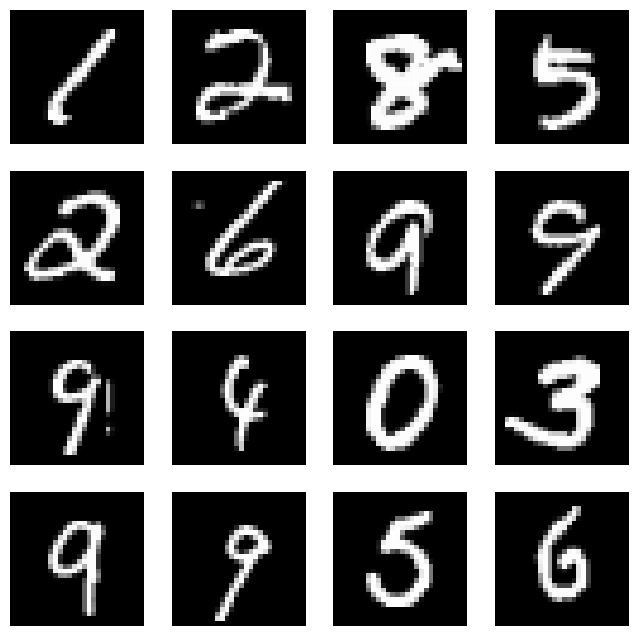

In [ ]:
 #!/usr/bin/env python3
# Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize W&B project
wandb.init(project="mnist_dcgan", config={
    "dataset": "MNIST",
    "framework": "PyTorch",
    "model": "DCGAN"
})

# Set seed for reproducibility
torch.manual_seed(42)

# Define preprocessing for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download MNIST training dataset
dataset = datasets.MNIST(root='./data',
                         train=True,
                         download=True,
                         transform=transform)

# Create DataLoader with batch size and shuffle
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get one batch to check shapes
real_batch = next(iter(dataloader))
images, labels = real_batch

# Print shape of batch to verify
print(images.shape)
print(labels.shape)

# Undo normalization for visual
images = images * 0.5 + 0.5
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Hyperparameters
latent_dim = 100
# lr = 0.002 # Original lr, now using lr_G and lr_D
lr_G = 0.0002 # Learning rate for the Generator
lr_D = 0.0002 # Learning rate for the Discriminator
img_ch = 1
img_size = 28
kernel = 4
Beta1 = 0.5
batch_size = 256
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Models


# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_ch):
        super(Generator, self).__init__()

        # Starting size will be 7x7 after first layer
        self.init_size = 7

        # Linear layer to expand latent vector
        self.fc = nn.Linear(latent_dim, 128 * self.init_size**2)

        self.conv_blocks = nn.Sequential(
          nn.BatchNorm2d(128),

          # Upsample to 14x14
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),

          # Upsample to 28x28
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True),

          # Output layer
          nn.Conv2d(32, img_ch, kernel, stride=1, padding=1),
          nn.Tanh()
          # Output range [-1, 1]
        )
    def forward(self, z):
        # z shape: (batch_size, latent_dim)
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

        # Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_ch):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: 1x28x28
            nn.Conv2d(img_ch, 64, kernel, stride=2, padding= 1),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(64, 128, kernel, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(128, 256, kernel, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            )
        self.adv_layer = nn.Sequential(
        # Flatten and output single value
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        # print(f"Input shape: {img.shape}")  # (128, 1, 28, 28)

        out = self.model(img)
        # print(f"After conv layers: {out.shape}")  # (128, 128, ?, ?)

        # out_flat = out.view(out.size(0), -1)  # Flatten manually
        # print(f"After flatten: {out_flat.shape}")  # (128, ???)

        validity = self.adv_layer(out)
        return validity

In [ ]:
# Training function
# Weight initialization (important for GANs)
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

def train_dcgan(dataloader, num_epochs, batch_size):

  # Initialize models
  generator = Generator(latent_dim, img_ch).to(device)
  discriminator = Discriminator(img_ch).to(device)

  # Apply weight initialization
  generator.apply(weights_init)
  discriminator.apply(weights_init)
  # Loss function
  bce_loss = nn.BCELoss()
  # Optimizers
  optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(Beta1, 0.999))
  optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(Beta1, 0.999))
  # update WandB
  wandb.config.update({
      "latent_dim": latent_dim,
      "batch_size": batch_size,
      "img_ch": img_ch,
      "img_size": img_size,
      "kernel": kernel,
      "Beta1": Beta1,
      "optimizer": "Adam",
      "lr_G": lr_G,
      "lr_D": lr_D,
      "num_epochs": num_epochs,
      "architecture": "Baseline DCGAN"
      })
  # wandb.watch(generator)
  # wandb.watch(discriminator)

  # Fixed noise for visualization
  fixed_noise = torch.randn(64, latent_dim).to(device)
  print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
  print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

  for epoch in range(num_epochs):
    for i, (real_imgs,_) in enumerate(dataloader):
      curr_batch_size = real_imgs.size(0) # Get current batch size
      real_imgs = real_imgs.to(device)

      # Labels for real and fake images, use curr_batch_size
      real_labels = torch.ones(curr_batch_size, 1).to(device)
      fake_labels = torch.zeros(curr_batch_size, 1).to(device)

      # ---------------------
      #  Train Discriminator
      # ---------------------

      optimizer_D.zero_grad()

      # Add Gaussian noise to real images
      noise_std = 0.3  # You can adjust this
      real_imgs_noisy = real_imgs + torch.randn_like(real_imgs) * noise_std

      # Loss on real images
      real_out = discriminator(real_imgs_noisy)
      d_real_loss = bce_loss(real_out, real_labels)

      # Generate fake images
      z = torch.randn(curr_batch_size, latent_dim).to(device) # Use curr_batch_size for fake images
      fake_imgs = generator(z)

      # Add Gaussian noise to fake images
      fake_imgs_noisy = fake_imgs.detach() + torch.randn_like(fake_imgs) * noise_std

      # Loss on fake images
      fake_out = discriminator(fake_imgs_noisy)
      d_fake_loss = bce_loss(fake_out, fake_labels)

      # Total discriminator loss
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      # nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
      optimizer_D.step()

      # -----------------
      #  Train Generator
      # -----------------
      optimizer_G.zero_grad()

      # Generate fake images
      z = torch.randn(curr_batch_size, latent_dim).to(device) # Use curr_batch_size for fake images
      fake_imgs = generator(z)

      # Loss on fake images
      fake_out = discriminator(fake_imgs)
      g_loss = bce_loss(fake_out, real_labels)

      # Generator tries to fool discriminator
      g_loss.backward()
      # nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
      optimizer_G.step()

      # ---------------------
      #  Log metrics
      # ---------------------

      # Print progress at every batch
      if (i+1) % 469 == 0:
        print(f"[Epoch {epoch+1}/{num_epochs}]\n"
        f"[Batch {i+1}/{len(dataloader)}]\n"
        f"D_loss: {d_loss.item():.4f}\n"
        f"G_loss: {g_loss.item():.4f}\n"
        f"G_acc: {(fake_out >= 0.5).float().mean().item():.4f}\n"
        f"D_real_acc: {(real_out >= 0.5).float().mean().item():.4f}\n"
        f"D_fake_acc: {(fake_out < 0.5).float().mean().item():.4f}")
    # Log to WandB at end of epoch
    log_interval = 1  # log every 10 batches
    if (i + 1) % log_interval == 0:
      wandb.log({
          "epoch": epoch,
          "d_loss": d_loss.item(),
          "g_loss": g_loss.item(),
          "d_real_acc": (real_out >= 0.5).float().mean().item(),
          "d_fake_acc": (fake_out < 0.5).float().mean().item(),
          "g_acc": (fake_out >= 0.5).float().mean().item(),
          })

    # Generate and log images every 5 epochs
    if epoch % 5 == 0: # Generate and log images every 5 epochs and every 100 batches
      with torch.no_grad():
        fake_imgs = generator(fixed_noise).detach().cpu()

        # Denormalize images from [-1, 1] to [0, 1]
        fake_imgs = (fake_imgs + 1) / 2
        # Create grid of images
        grid = torchvision.utils.make_grid(fake_imgs,
                                           nrow=8,
                                           padding=2,
                                           normalize=False)
        # Log to WandB
        wandb.log({"generated_images": wandb.Image(grid)})
        save_image(fake_imgs[:64],f'generated_epoch_{epoch}.png', nrow=8, padding=2, normalize=False)


# Save final models
  torch.save(generator.state_dict(), "generator.pth")
  torch.save(discriminator.state_dict(), "discriminator.pth")
  wandb.save("generator.pth")
  wandb.save("discriminator.pth")

  return generator, discriminator

In [ ]:
  # Main execution
# if __name__ == "__main__":
  # Train the DCGAN
generator, discriminator = train_dcgan(dataloader, epochs, batch_size)
wandb.finish()

Generator parameters: 798,369
Discriminator parameters: 659,905
[Epoch 1/50]
[Batch 469/469]
D_loss: 0.0001
G_loss: 9.7104
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 2/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 10.8046
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 3/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 11.8441
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 4/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 12.4818
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 5/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 13.1505
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 6/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 13.4602
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 7/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 13.7666
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 8/50]
[Batch 469/469]
D_loss: 0.0000
G_loss: 14.3469
G_acc: 0.0000
D_real_acc: 1.0000
D_fake_acc: 1.0000
[Epoch 9/50]
[Batch 469/469]
D_loss: 0.00

d_fake_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_real_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
g_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
g_loss,▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
d_fake_acc,1
d_loss,0.0
d_real_acc,1
epoch,49
g_acc,0


In [ ]:
 print(f"Using device: {device}")

Using device: cuda
